In [5]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, Bidirectional, LSTM, TimeDistributed, Lambda, Softmax, Multiply, Conv1D, RepeatVector
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf

The main idea here is that sequences are strings and many LLM architectures can be utilized.

In [6]:
def load_data(file):
    file = str(file)
    df = pd.read_json(f'{file}.json',lines=True,)
    print(f'{file} Shape: ', df.shape)

    return df
    
train_df = load_data('train')
test_df = load_data('test')

train Shape:  (2400, 19)
test Shape:  (3634, 7)


In [7]:
train_df.head(5)

,index,id,sequence,structure,predicted_loop_type,signal_to_noise,SN_filter,seq_length,seq_scored,reactivity_error,deg_error_Mg_pH10,deg_error_pH10,deg_error_Mg_50C,deg_error_50C,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081,GGAAAAGCUCUAAUAACAGGAGACUAGGACUACGUAUUUCUAGGUA...,.....((((((.......)))).)).((.....((..((((((......,EEEEESSSSSSHHHHHHHSSSSBSSXSSIIIIISSIISSSSSSHHH...,6.894,1,107,68,"[0.1359, 0.20700000000000002, 0.1633, 0.1452, ...","[0.26130000000000003, 0.38420000000000004, 0.1...","[0.2631, 0.28600000000000003, 0.0964, 0.1574, ...","[0.1501, 0.275, 0.0947, 0.18660000000000002, 0...","[0.2167, 0.34750000000000003, 0.188, 0.2124, 0...","[0.3297, 1.5693000000000001, 1.1227, 0.8686, 0...","[0.7556, 2.983, 0.2526, 1.3789, 0.637600000000...","[2.3375, 3.5060000000000002, 0.3008, 1.0108, 0...","[0.35810000000000003, 2.9683, 0.2589, 1.4552, ...","[0.6382, 3.4773, 0.9988, 1.3228, 0.78770000000..."
1,1,id_0049f53ba,GGAAAAAGCGCGCGCGGUUAGCGCGCGCUUUUGCGCGCGCUGUACC...,.....(((((((((((((((((((((((....)))))))))).)))...,EEEEESSSSSSSSSSSSSSSSSSSSSSSHHHHSSSSSSSSSSBSSS...,0.193,0,107,68,"[2.8272, 2.8272, 2.8272, 4.7343, 2.5676, 2.567...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[10.1986, 9.2418, 5.0933, 5.0933, 5.0933, 5.09...","[16.6174, 13.868, 8.1968, 8.1968, 8.1968, 8.19...","[15.4857, 7.9596, 13.3957, 5.8777, 5.8777, 5.8...","[0.0, 0.0, 0.0, 2.2965, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.947, 4.4523, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4.8511, 4.0426, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[7.6692, 0.0, 10.9561, 0.0, 0.0, 0.0, 0.0, 0.0..."
2,2,id_006f36f57,GGAAAGUGCUCAGAUAAGCUAAGCUCGAAUAGCAAUCGAAUAGAAU...,.....((((.((.....((((.(((.....)))..((((......)...,EEEEESSSSISSIIIIISSSSMSSSHHHHHSSSMMSSSSHHHHHHS...,8.800,1,107,68,"[0.0931, 0.13290000000000002, 0.11280000000000...","[0.1365, 0.2237, 0.1812, 0.1333, 0.1148, 0.160...","[0.17020000000000002, 0.178, 0.111, 0.091, 0.0...","[0.1033, 0.1464, 0.1126, 0.09620000000000001, ...","[0.14980000000000002, 0.1761, 0.1517, 0.116700...","[0.44820000000000004, 1.4822, 1.1819, 0.743400...","[0.2504, 1.4021, 0.9804, 0.49670000000000003, ...","[2.243, 2.9361, 1.0553, 0.721, 0.6396000000000...","[0.5163, 1.6823000000000001, 1.0426, 0.7902, 0...","[0.9501000000000001, 1.7974999999999999, 1.499..."
3,3,id_0082d463b,GGAAAAGCGCGCGCGCGCGCGCGAAAAAGCGCGCGCGCGCGCGCGC...,......((((((((((((((((......))))))))))))))))((...,EEEEEESSSSSSSSSSSSSSSSHHHHHHSSSSSSSSSSSSSSSSSS...,0.104,0,107,68,"[3.5229, 6.0748, 3.0374, 3.0374, 3.0374, 3.037...","[73705.3985, 73705.3985, 73705.3985, 73705.398...","[11.8007, 12.7566, 5.7733, 5.7733, 5.7733, 5.7...","[121286.7181, 121286.7182, 121286.7181, 121286...","[15.3995, 8.1124, 7.7824, 7.7824, 7.7824, 7.78...","[0.0, 2.2399, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....","[0.0, -0.5083, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[3.4248, 6.8128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, -0.8365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...","[7.6692, -1.3223, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
4,4,id_0087940f4,GGAAAAUAUAUAAUAUAUUAUAUAAAUAUAUUAUAGAAGUAUAAUA...,.....(((((((.((((((((((((.(((((((((....)))))))...,EEEEESSSSSSSBSSSSSSSSSSSSBSSSSSSSSSHHHHSSSSSSS...,0.423,0,107,68,"[1.665, 2.1728, 2.0041, 1.2405, 0.620200000000...","[4.2139, 3.9637000000000002, 3.2467, 2.4716, 1...","[3.0942, 3.015, 2.1212, 2.0552, 0.881500000000...","[2.6717, 2.4818, 1.9919, 2.5484999999999998, 1...","[1.3285, 3.6173, 1.3057, 1.3021, 1.1507, 1.150...","[0.8267, 2.6577, 2.8481, 0.40090000000000003, ...","[2.1058, 3.138, 2.5437000000000003, 1.0932, 0....","[4.7366, 4.6243, 1.2068, 1.1538, 0.0, 0.0, 0.7...","[2.2052, 1.7947000000000002, 0.7457, 3.1233, 0...","[0.0, 5.1198, -0.3551, -0.3518, 0.0, 0.0, 0.0,..."


In [8]:
# ---------------------- STATICS -----------------------------#
MAX_SEQ_LENGTH = 130 
EMBEDDING_DIM = 16
LSTM_UNITS = 64
DENSE_UNITS = 32
DROPOUT_RATE = 0.3 
# ------------------------------------------------------------#

In [9]:
def one_hot_encode_sequence(seq, max_length):
    nucleotide_to_int = {'A': 0, 'G': 1, 'C': 2, 'U': 3}
    seq_encoded = [nucleotide_to_int[nuc] for nuc in seq]
    one_hot = np.zeros((max_length, 4))
    for idx, nuc_idx in enumerate(seq_encoded):
        if idx < max_length:
            one_hot[idx, nuc_idx] = 1
    return one_hot

def encode_structure(structure, max_length):
    struct_encoded = [1 if s in '()' else 0 for s in structure]
    struct_padded = struct_encoded + [0] * (max_length - len(struct_encoded))
    struct_padded = struct_padded[:max_length]
    struct_padded = np.array(struct_padded)[:, np.newaxis]  # Reshape to (max_length, 1)
    return struct_padded

def one_hot_encode_loop_type(loop_seq, max_length):
    loop_types = ['S', 'M', 'I', 'B', 'H', 'E', 'X']
    loop_type_to_int = {lt: idx for idx, lt in enumerate(loop_types)}
    loop_encoded = [loop_type_to_int[lt] for lt in loop_seq]
    one_hot = np.zeros((max_length, len(loop_types)))
    for idx, lt_idx in enumerate(loop_encoded):
        if idx < max_length:
            one_hot[idx, lt_idx] = 1
    return one_hot

In [10]:
def get_pairing_info(structure_sequence, max_length):
    stack = []
    pairing_status = [0] * len(structure_sequence)
    pairing_partner = [-1] * len(structure_sequence)
    for i, char in enumerate(structure_sequence):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                j = stack.pop()
                pairing_status[i] = pairing_status[j] = 1
                pairing_partner[i] = j
                pairing_partner[j] = i

    pairing_status_padded = pairing_status + [0] * (max_length - len(pairing_status))
    pairing_partner_padded = pairing_partner + [-1] * (max_length - len(pairing_partner))
    pairing_status_padded = pairing_status_padded[:max_length]
    pairing_partner_padded = pairing_partner_padded[:max_length]
    return pairing_status_padded, pairing_partner_padded

In [11]:
def compute_pairing_distances(pairing_partner, max_length):
    distances = [abs(i - p) if p != -1 else 0 for i, p in enumerate(pairing_partner)]
    max_distance = max(distances) if max(distances) > 0 else 1
    normalized_distances = [d / max_distance for d in distances]
    distances_padded = normalized_distances + [0] * (max_length - len(normalized_distances))
    distances_padded = distances_padded[:max_length]
    distances_padded = np.array(distances_padded)[:, np.newaxis]
    return distances_padded

In [12]:
def compute_closest_distances(structure_sequence, max_length):
    paired_positions = [i for i, s in enumerate(structure_sequence) if s in '()']
    unpaired_positions = [i for i, s in enumerate(structure_sequence) if s == '.']

    closest_paired = []
    closest_unpaired = []
    for i in range(len(structure_sequence)):
        if paired_positions:
            dist_paired = min([abs(i - j) for j in paired_positions])
        else:
            dist_paired = max_length
        if unpaired_positions:
            dist_unpaired = min([abs(i - j) for j in unpaired_positions])
        else:
            dist_unpaired = max_length
        closest_paired.append(dist_paired)
        closest_unpaired.append(dist_unpaired)

    # Normalize distances
    closest_paired = [d / max_length for d in closest_paired]
    closest_unpaired = [d / max_length for d in closest_unpaired]

    # Padding
    closest_paired += [1.0] * (max_length - len(closest_paired))
    closest_unpaired += [1.0] * (max_length - len(closest_unpaired))

    return closest_paired[:max_length], closest_unpaired[:max_length]

In [13]:
def calculate_nucleotide_percentages(sequence):
    counts = Counter(sequence)
    total = len(sequence)
    
    percentages = {
        'A': counts.get('A', 0) / total,
        'G': counts.get('G', 0) / total,
        'C': counts.get('C', 0) / total,
        'U': counts.get('U', 0) / total
    }
    
    return [percentages['A'], percentages['G'], percentages['C'], percentages['U']]

In [14]:
def preprocess_data(df, max_length):
    sequences = df['sequence'].tolist()
    structures = df['structure'].tolist()
    loop_types = df['predicted_loop_type'].tolist()

    seq_encoded = [one_hot_encode_sequence(seq, max_length) for seq in sequences]
    struct_encoded = [encode_structure(struct, max_length) for struct in structures]
    loop_encoded = [one_hot_encode_loop_type(loop, max_length) for loop in loop_types]

    pairing_status_list = []
    distances_list = []
    closest_paired_list = []
    closest_unpaired_list = []
    for struct in structures:
        pairing_status, pairing_partner = get_pairing_info(struct, max_length)
        distances = compute_pairing_distances(pairing_partner, max_length)
        pairing_status_list.append(np.array(pairing_status)[:, np.newaxis])  # Shape: (max_length, 1)
        distances_list.append(distances)

        cp, cu = compute_closest_distances(struct, max_length)
        closest_paired_list.append(cp)       
        closest_unpaired_list.append(cu)  

    nucleotide_percentages = [calculate_nucleotide_percentages(seq) for seq in sequences]

    seq_encoded = np.array(seq_encoded)  # Shape: (samples, max_length, 4)
    struct_encoded = np.array(struct_encoded)  # Shape: (samples, max_length, 1)
    loop_encoded = np.array(loop_encoded)  # Shape: (samples, max_length, num_loop_types)
    pairing_status_array = np.array(pairing_status_list)  # Shape: (samples, max_length, 1)
    distances_array = np.array(distances_list)  # Shape: (samples, max_length, 1)
    closest_paired_array = np.array(closest_paired_list)  # Shape: (samples, max_length, 1)
    closest_unpaired_array = np.array(closest_unpaired_list)  # Shape: (samples, max_length, 1)
    nucleotide_percentages_array = np.array(nucleotide_percentages)  # Shape: (samples, 4)

    return {
        'seq_input': seq_encoded,
        'struct_input': struct_encoded,
        'loop_input': loop_encoded,
        'pairing_status_input': pairing_status_array,
        'distance_input': distances_array,
        'closest_paired_input': closest_paired_array,
        'closest_unpaired_input': closest_unpaired_array,
        'global_input': nucleotide_percentages_array
    }

In [15]:
def pad_targets(targets, max_length):
    padded_targets = [t + [np.nan] * (max_length - len(t)) for t in targets]
    return np.array(padded_targets)[:, :, np.newaxis]

In [16]:
def calculate_sample_weights(df):
    lengths = df['sequence'].apply(len)
    sample_weights = 1 / np.sqrt(lengths)

    sample_weights /= sample_weights.mean()
    return sample_weights.values

In [17]:
def masked_mse(y_true, y_pred):
    mask = tf.math.logical_not(tf.math.is_nan(y_true))
    mask = tf.cast(mask, dtype=tf.float32)
    mse = tf.square(y_pred - tf.where(mask == 1, y_true, tf.zeros_like(y_true))) * mask
    return tf.reduce_sum(mse) / tf.reduce_sum(mask)


In [50]:
MAX_SEQ_LENGTH = 107
LSTM_UNITS = 128
DENSE_UNITS = 64
DROPOUT_RATE = 0.1
EPOCHS = 30
BATCH_SIZE = 32

In [19]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

train_inputs = preprocess_data(train_df, MAX_SEQ_LENGTH)
train_targets = pad_targets(train_df['reactivity'].tolist(), MAX_SEQ_LENGTH)
train_sample_weights = calculate_sample_weights(train_df)

val_inputs = preprocess_data(val_df, MAX_SEQ_LENGTH)
val_targets = pad_targets(val_df['reactivity'].tolist(), MAX_SEQ_LENGTH)
val_sample_weights = calculate_sample_weights(val_df)

In [25]:
def attention_layer(inputs):
    a = Dense(1, activation='tanh')(inputs)
    a = Lambda(lambda x: tf.squeeze(x, axis=-1), output_shape=lambda s: (s[0], s[1]))(a)
    a = Softmax()(a)
    a = Lambda(lambda x: tf.expand_dims(x, axis=-1), output_shape=lambda s: (s[0], s[1], 1))(a)
    output = Multiply()([inputs, a])
    return output


def build_model(max_seq_length, num_loop_types, lstm_units, dense_units, dropout_rate):

    seq_input = Input(shape=(max_seq_length, 4), name='seq_input')
    struct_input = Input(shape=(max_seq_length, 1), name='struct_input')
    loop_input = Input(shape=(max_seq_length, num_loop_types), name='loop_input')
    pairing_status_input = Input(shape=(max_seq_length, 1), name='pairing_status_input')
    distance_input = Input(shape=(max_seq_length, 1), name='distance_input')
    closest_paired_input = Input(shape=(max_seq_length, 1), name='closest_paired_input')
    closest_unpaired_input = Input(shape=(max_seq_length, 1), name='closest_unpaired_input')
    global_input = Input(shape=(4,), name='global_input')

    features = Concatenate(axis=-1)([
        seq_input,
        struct_input,
        loop_input,
        pairing_status_input,
        distance_input,
        closest_paired_input,
        closest_unpaired_input
    ])

    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(features)
    x = Dropout(dropout_rate)(x)

    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units // 2, return_sequences=True))(x)
    x = Dropout(dropout_rate)(x)

    x = attention_layer(x)

    sequence_length = max_seq_length
    global_features_repeated = RepeatVector(sequence_length)(global_input)
    x = Concatenate(axis=-1)([x, global_features_repeated])

    x = TimeDistributed(Dense(dense_units, activation='relu'))(x)
    x = Dropout(dropout_rate)(x)
    output = TimeDistributed(Dense(1))(x)

    model = Model(
        inputs=[
            seq_input,
            struct_input,
            loop_input,
            pairing_status_input,
            distance_input,
            closest_paired_input,
            closest_unpaired_input,
            global_input
        ],
        outputs=output
    )

    model.compile(optimizer='adam', loss=masked_mse)

    return model

In [26]:
loop_types = ['S', 'M', 'I', 'B', 'H', 'E', 'X']
num_loop_types = len(loop_types)

model = build_model(
    max_seq_length=MAX_SEQ_LENGTH,
    num_loop_types=num_loop_types,
    lstm_units=LSTM_UNITS,
    dense_units=DENSE_UNITS,
    dropout_rate=DROPOUT_RATE
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq_input (InputLayer)        │ (None, 107, 4)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ struct_input (InputLayer)     │ (None, 107, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ loop_input (InputLayer)       │ (None, 107, 7)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pairing_status_input          │ (None, 107, 1)            │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distance_input (InputLayer)   │ (None, 107, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ closest_paired_input          │ (None, 107, 1)            │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ closest_unpaired_input        │ (None, 107, 1)            │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 107, 16)           │               0 │ seq_input[0][0],           │
│                               │                           │                 │ struct_input[0][0],        │
│                               │                           │                 │ loop_input[0][0],          │
│                               │                           │                 │ pairing_status_input[0][0… │
│                               │                           │                 │ distance_input[0][0],      │
│                               │                           │                 │ closest_paired_input[0][0… │
│                               │                           │                 │ closest_unpaired_input[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 107, 64)           │           3,136 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 107, 64)           │               0 │ conv1d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_4               │ (None, 107, 256)          │         197,632 │ dropout_7[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 107, 256)          │               0 │ bidirectional_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 373,826 (1.43 MB)

 Trainable params: 373,826 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
EPOCHS = 30
BATCH_SIZE = 32

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    x=train_inputs,
    y=train_targets,
    sample_weight=train_sample_weights,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(val_inputs, val_targets, val_sample_weights),
    callbacks=[early_stopping]
)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 125ms/step - loss: 0.5008 - val_loss: 0.5437
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.4132 - val_loss: 0.4952
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.3725 - val_loss: 0.4876
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.4017 - val_loss: 0.4817
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.4180 - val_loss: 0.4796
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.4263 - val_loss: 0.4753
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.4271 - val_loss: 0.4751
Epoch 8/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.3789 - val_loss: 0.4728
Epoch 9/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.3840 - val_loss: 0.4715
Epoch 10/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.3470 - val_loss: 0.4746
Epoch 11/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - loss: 0.3978 - val_loss: 0.4686
Epoch 12/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Validation MSE: 0.4480
Validation RMSE: 0.6694
Validation MAE: 0.1979


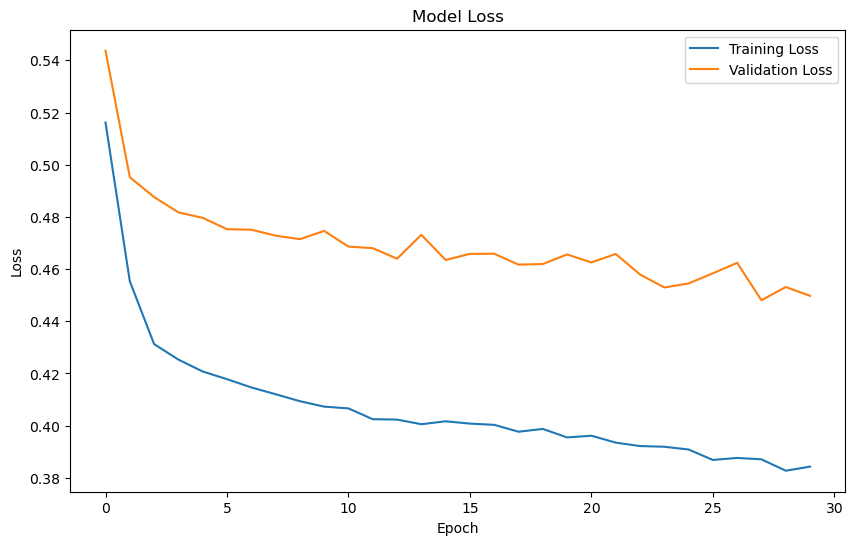

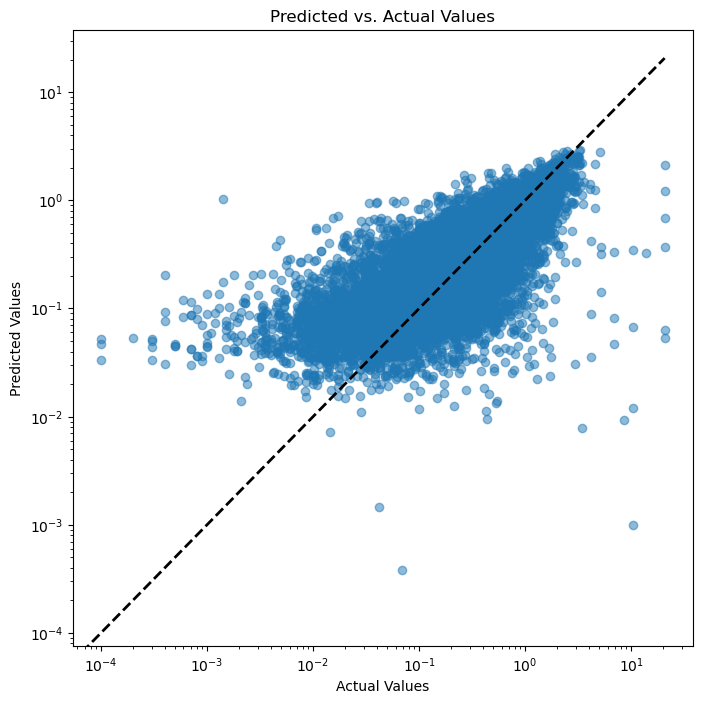

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Predict on validation inputs
val_predictions = model.predict(val_inputs)

# Flatten the targets and predictions
val_targets_flat = val_targets.flatten()
val_predictions_flat = val_predictions.flatten()

# Create a mask to ignore NaN values in val_targets_flat
mask = ~np.isnan(val_targets_flat)

# Filter the targets and predictions using the mask
val_targets_flat = val_targets_flat[mask]
val_predictions_flat = val_predictions_flat[mask]

# Calculate MSE, RMSE, MAE
mse = mean_squared_error(val_targets_flat, val_predictions_flat)
rmse = math.sqrt(mse)
mae = mean_absolute_error(val_targets_flat, val_predictions_flat)

print(f"Validation MSE: {mse:.4f}")
print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE: {mae:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot predicted vs actual values
plt.figure(figsize=(8, 8))
plt.xscale('log')
plt.yscale('log')
plt.scatter(val_targets_flat, val_predictions_flat, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. Actual Values')
plt.plot([val_targets_flat.min(), val_targets_flat.max()], [val_targets_flat.min(), val_targets_flat.max()], 'k--', lw=2)
plt.show()


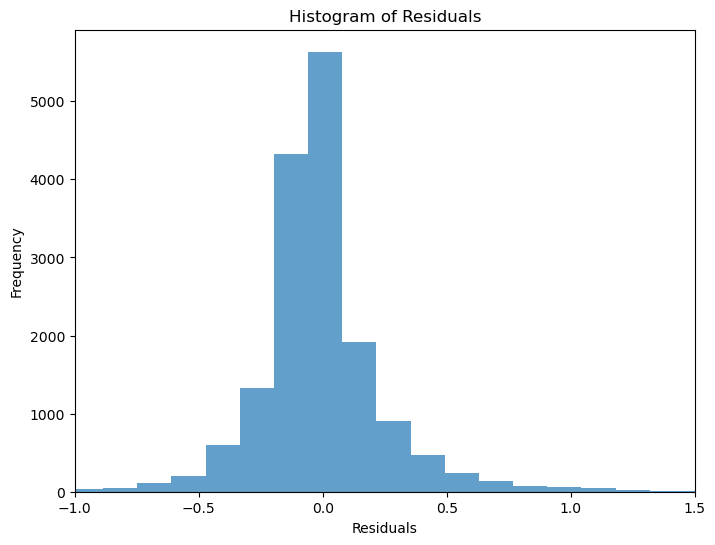

In [35]:
residuals = val_targets_flat - val_predictions_flat
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=300, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.xlim(-1,1.5)
plt.show()

(-0.5, 3.0)

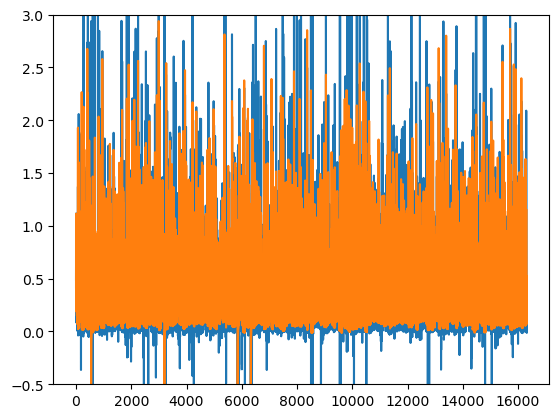

In [56]:
plt.plot(val_targets_flat)
plt.plot(val_predictions_flat)
plt.ylim(-0.5,3)